# Developing the Training Set Sightlines

In [22]:
%matplotlib notebook

In [2]:
# imports
from matplotlib import pyplot as plt

from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from specdb.specdb import IgmSpec
from pyigm.surveys.dlasurvey import DLASurvey

## Load Complete DR5

In [3]:
sdssdr5 = DLASurvey.load_SDSS_DR5(sample='all')

SDSS-DR5: Loading DLA file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_alldla.fits.gz
SDSS-DR5: Loading QSOs file /Users/xavier/local/Python/pyigm/pyigm/data/DLA/SDSS_DR5/dr5_dlagz_s2n4.fits


### Sightlines

In [4]:
sdssdr5.sightlines[0:4]

PLATE,FIB,RA,DEC,FLG_BAL,IQSO,MAG,S2N,Z_START,Z_END,ZEM,DX
,,deg,deg,,,,,,,,
int32,int32,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64
266,5,146.93861,-0.68701194,1,0,19.341999054,4.94595003128,2.39664643878,2.74649000168,2.8287498951,1.17426266257
266,92,146.22601,-0.72509875,0,4,19.0820007324,8.54980564117,2.20000004768,2.25759506226,2.29049992561,0.184012498912
270,254,152.23239,-0.97123272,0,9,19.0230007172,7.49763822556,2.30636157714,3.0556242466,3.09659004211,2.56581152274
271,391,154.14992,0.14750838,0,16,18.0650005341,18.982629776,2.20000004768,2.25551605225,2.28839993477,0.177634457341


### Coords

In [5]:
dla_coord = sdssdr5.coord

In [6]:
sl_coord = SkyCoord(ra=sdssdr5.sightlines['RA'], dec=sdssdr5.sightlines['DEC'])

## Identify sightlines

### Find sightlines without a DLA

In [7]:
idx, d2d, d3d = match_coordinates_sky(sl_coord, dla_coord, nthneighbor=1)

In [8]:
clear = d2d > 1*u.arcsec

In [9]:
nclear = np.sum(clear)
nclear

6532

In [10]:
keep = clear

### Sightlines without any hint of a BAL?
    i.e. avoid FLG_BAL==1
    But, it may be good to train with those in there [with and witout input DLA, of course]

In [11]:
np.max(sdssdr5.sightlines['FLG_BAL'])

1

### S/N?
    Probably should cut at S/N=5

<IPython.core.display.Javascript object>


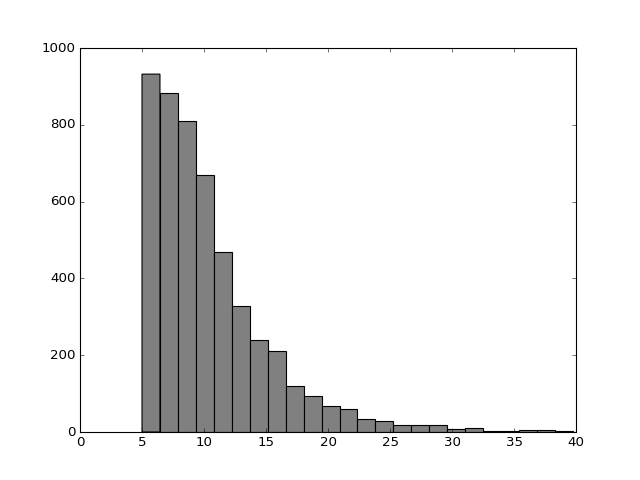

In [23]:
plt.clf()
ax = plt.gca()
ax.hist(sdssdr5.sightlines['S2N'][keep], bins=50, color='grey')
ax.set_xlim(0., 40.)
plt.show()

In [13]:
s2n_cut = 5.

In [14]:
gd_s2n = sdssdr5.sightlines['S2N'] > s2n_cut

In [15]:
keep = clear & gd_s2n
np.sum(keep)

5034

### Cut on $\Delta X$?
    This would mainly remove low z quasars

<IPython.core.display.Javascript object>


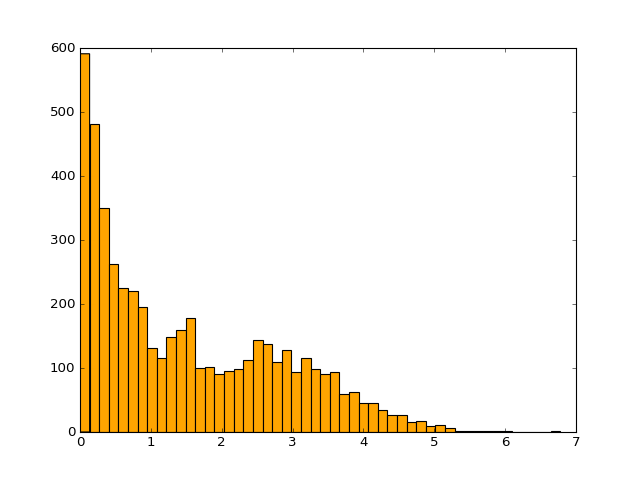

In [24]:
plt.clf()
ax = plt.gca()
ax.hist(sdssdr5.sightlines['DX'][keep], bins=50, color='orange')
#ax.set_xlim(0., 40.)
plt.show()

<IPython.core.display.Javascript object>


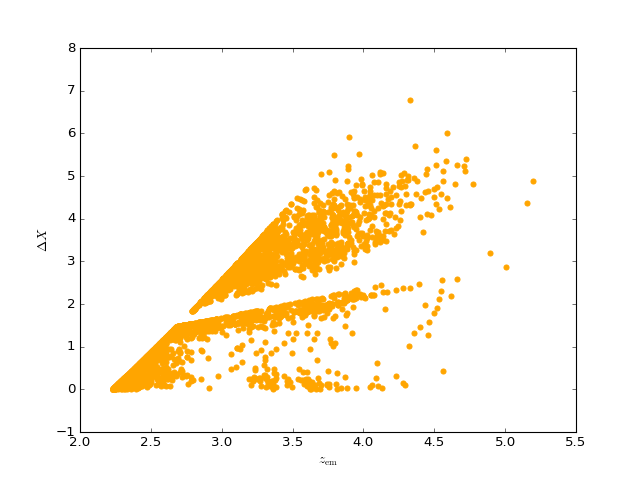

In [25]:
plt.clf()
ax = plt.gca()
ax.scatter(sdssdr5.sightlines['ZEM'][keep], sdssdr5.sightlines['DX'][keep], color='orange')
ax.set_xlabel(r'$z_{\rm em}$')
ax.set_ylabel(r'$\Delta X$')
plt.show()

## Assess sightlines

### Number

In [18]:
nsight = np.sum(keep)
print("We have {:d} sightlines for the training set".format(nsight))

We have 5034 sightlines for the training set


### $z_{\rm em}$
    Given the distribution below, should we uniformly sample zem?  Probably..
    Or should we supplement with ESI?

<IPython.core.display.Javascript object>


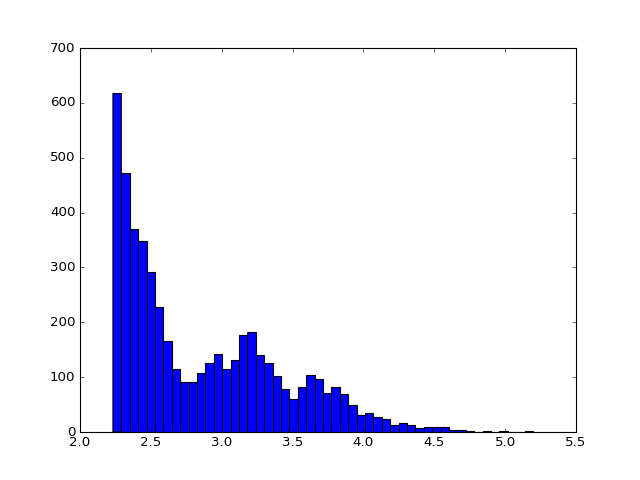

In [26]:
plt.clf()
ax = plt.gca()
ax.hist(sdssdr5.sightlines['ZEM'][keep], bins=50)
#ax.set_xlim(0., 40.)
plt.show()

### Magnitude
    These are pretty bright
    But the value of adding ones with lower S/N is questionable

<IPython.core.display.Javascript object>


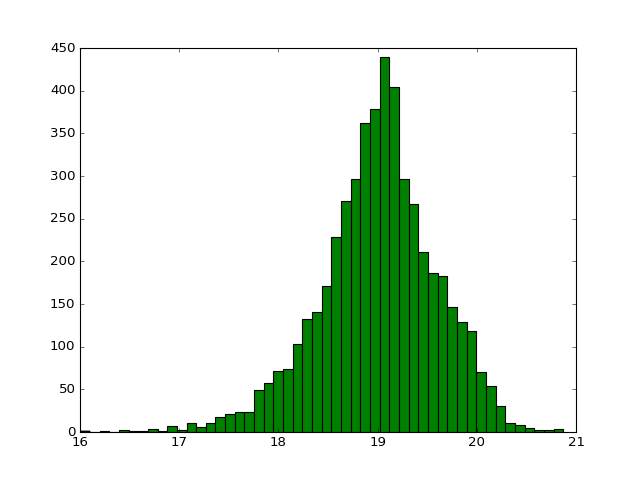

In [27]:
plt.clf()
ax = plt.gca()
ax.hist(sdssdr5.sightlines['MAG'][keep], bins=50, color='green')
#ax.set_xlim(0., 40.)
plt.show()

### Examine a few

In [30]:
igmsp = IgmSpec()

Using /raid/IGMSPEC_DB/IGMspec_DB_v02.hdf5 for the catalog file
Using /raid/IGMSPEC_DB/IGMspec_DB_v02.hdf5 for the DB file
Available surveys: [u'BOSS_DR12', u'HSTQSO', u'SDSS_DR7', u'KODIAQ_DR1', u'MUSoDLA', u'HD-LLS_DR1', u'2QZ', u'ESI_DLA', u'HDLA100', u'GGG', u'COS-Halos', u'HST_z2', u'COS-Dwarfs', u'XQ-100']
Database is igmspec
Created on 2016-Oct-25


In [21]:
kidx = np.where(keep)[0]

#### 0
    zem = 2.29

In [31]:
k0 = kidx[0]
s0 = sdssdr5.sightlines[k0]
s0

PLATE,FIB,RA,DEC,FLG_BAL,IQSO,MAG,S2N,Z_START,Z_END,ZEM,DX
,,deg,deg,,,,,,,,
int32,int32,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64
266,92,146.22601,-0.72509875,0,4,19.0820007324,8.54980564117,2.20000004768,2.25759506226,2.29049992561,0.184012498912


In [35]:
spec, meta = igmsp.spec_from_coord((s0['RA'], s0['DEC']), isurvey=['SDSS_DR7'])
spec[0]

Your search yielded 1 match[es]
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<XSpectrum1D: file=none, nspec=1, select=0, wvmin=3823.84 Angstrom, wvmax=9202.38 Angstrom>

<IPython.core.display.Javascript object>


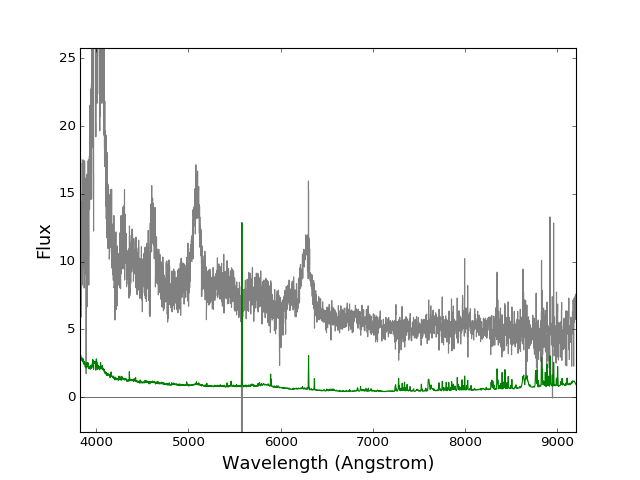

In [36]:
spec[0].plot()

#### 100

In [37]:
k100 = kidx[100]
s100 = sdssdr5.sightlines[k100]
s100

PLATE,FIB,RA,DEC,FLG_BAL,IQSO,MAG,S2N,Z_START,Z_END,ZEM,DX
,,deg,deg,,,,,,,,
int32,int32,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64
301,267,208.99597,-0.4037675,1,521,18.2290000916,14.378821373,2.20000004768,2.26157999039,2.3438398838,0.196775568722


Your search yielded 1 match[es]
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


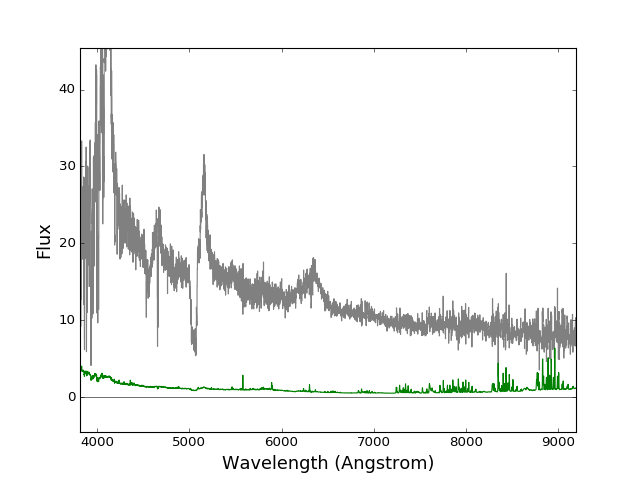

In [38]:
spec100, meta = igmsp.spec_from_coord((s100['RA'], s100['DEC']), isurvey=['SDSS_DR7'])
spec100[0].plot()

#### Pick one at z=3

In [41]:
i3 = np.argmin(np.abs(sdssdr5.sightlines['ZEM'][keep]-3.))
k3 = kidx[i3]               
s3 = sdssdr5.sightlines[k3]
s3

PLATE,FIB,RA,DEC,FLG_BAL,IQSO,MAG,S2N,Z_START,Z_END,ZEM,DX
,,deg,deg,,,,,,,,
int32,int32,float64,float64,int16,int32,float64,float64,float64,float64,float64,float64
1595,148,147.77988,35.382061,0,23080,19.4699993134,5.45183944702,2.31856512541,2.96044540405,3.00044989586,2.17923800687


Your search yielded 1 match[es]
Staged 1 spectra totalling 6.4e-05 Gb
Loaded spectra


<IPython.core.display.Javascript object>


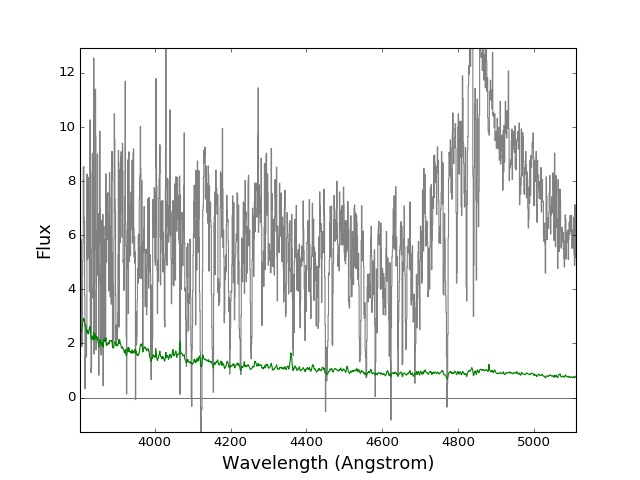

In [44]:
spec3, meta = igmsp.spec_from_coord((s3['RA'], s3['DEC']), isurvey=['SDSS_DR7'])
spec3[0].plot()